## Add Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

## Read In Data

In [2]:
df = pd.read_csv("data/pokedex.csv", index_col=0)
df

,dex_no,image,name,type1,type2,image_name
0,1,https://img.pokemondb.net/sprites/home/normal/...,Bulbasaur,Grass,Poison,bulbasaur.jpg
1,2,https://img.pokemondb.net/sprites/home/normal/...,Ivysaur,Grass,Poison,ivysaur.jpg
2,3,https://img.pokemondb.net/sprites/home/normal/...,Venusaur,Grass,Poison,venusaur.jpg
3,4,https://img.pokemondb.net/sprites/home/normal/...,Charmander,Fire,NaN,charmander.jpg
4,5,https://img.pokemondb.net/sprites/home/normal/...,Charmeleon,Fire,NaN,charmeleon.jpg
...,...,...,...,...,...,...
1005,1006,https://img.pokemondb.net/sprites/scarlet-viol...,Iron Valiant,Fairy,Fighting,iron-valiant.png
1006,1007,https://img.pokemondb.net/sprites/scarlet-viol...,Koraidon,Fighting,Dragon,koraidon.png
1007,1008,https://img.pokemondb.net/sprites/scarlet-viol...,Miraidon,Electric,Dragon,miraidon.png
1008,1009,https://img.pokemondb.net/sprites/scarlet-viol...,Walking Wake,Water,Dragon,walking-wake.png


## Split Folders for Train-Test and By Class

In [3]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.7, 0.0, 0.3)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = df.loc[df.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = df.loc[df.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df = pd.concat(pdList)
df

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_25735/1027188224.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_25735/1027188224.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"


,dex_no,image,name,type1,type2,image_name,split
0,1,https://img.pokemondb.net/sprites/home/normal/...,Bulbasaur,Grass,Poison,bulbasaur.jpg,train
1,2,https://img.pokemondb.net/sprites/home/normal/...,Ivysaur,Grass,Poison,ivysaur.jpg,train
2,3,https://img.pokemondb.net/sprites/home/normal/...,Venusaur,Grass,Poison,venusaur.jpg,train
3,4,https://img.pokemondb.net/sprites/home/normal/...,Charmander,Fire,NaN,charmander.jpg,train
4,5,https://img.pokemondb.net/sprites/home/normal/...,Charmeleon,Fire,NaN,charmeleon.jpg,train
...,...,...,...,...,...,...,...
984,985,https://img.pokemondb.net/sprites/scarlet-viol...,Scream Tail,Fairy,Psychic,scream-tail.png,test
991,992,https://img.pokemondb.net/sprites/scarlet-viol...,Iron Hands,Fighting,Electric,iron-hands.png,test
997,998,https://img.pokemondb.net/sprites/scarlet-viol...,Baxcalibur,Dragon,Ice,baxcalibur.png,test
999,1000,https://img.pokemondb.net/sprites/scarlet-viol...,Gholdengo,Steel,Ghost,gholdengo.png,test


In [5]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'

for index, row in df.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))     
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label, filename))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label, filename))

In [10]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (224, 224), color_mode ='rgb', 
                                                    batch_size = 25, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size = (224, 224), batch_size = 25,
                                             class_mode='categorical')

Found 707 images belonging to 18 classes.
Found 303 images belonging to 18 classes.


## Base Model

In [25]:
reg = l2(3e-3)
model = Sequential()
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(18, activation='softmax', kernel_regularizer = reg))

In [26]:
bce = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])

In [27]:
base_model = model.fit(
        train_generator, 
        validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 12:04:16.816052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 27.0428 - accuracy: 0.0636

2023-03-27 12:04:18.734008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 3s 86ms/step - loss: 27.0428 - accuracy: 0.0636 - val_loss: 11.8420 - val_accuracy: 0.1485
Epoch 2/100
29/29 [==============================] - 2s 83ms/step - loss: 6.7223 - accuracy: 0.0580 - val_loss: 6.3344 - val_accuracy: 0.1287
Epoch 3/100
29/29 [==============================] - 2s 82ms/step - loss: 4.3162 - accuracy: 0.0721 - val_loss: 3.6135 - val_accuracy: 0.0990
Epoch 4/100
29/29 [==============================] - 2s 84ms/step - loss: 3.5757 - accuracy: 0.0849 - val_loss: 3.4794 - val_accuracy: 0.1782
Epoch 5/100
29/29 [==============================] - 2s 82ms/step - loss: 3.6647 - accuracy: 0.0948 - val_loss: 4.2053 - val_accuracy: 0.1485
Epoch 6/100
29/29 [==============================] - 2s 82ms/step - loss: 3.5012 - accuracy: 0.0891 - val_loss: 3.4381 - val_accuracy: 0.1122
Epoch 7/100
29/29 [==============================] - 2s 82ms/step - loss: 3.4010 - accuracy: 0.0962 - val_loss: 3.3622 - val_accuracy: 0.1287
Epoch 8/100
29/2

29/29 [==============================] - 2s 83ms/step - loss: 3.1303 - accuracy: 0.1301 - val_loss: 3.1060 - val_accuracy: 0.1386
Epoch 59/100
29/29 [==============================] - 2s 83ms/step - loss: 3.1025 - accuracy: 0.1301 - val_loss: 3.0793 - val_accuracy: 0.1386
Epoch 60/100
29/29 [==============================] - 2s 82ms/step - loss: 3.0774 - accuracy: 0.1301 - val_loss: 3.0547 - val_accuracy: 0.1386
Epoch 61/100
29/29 [==============================] - 2s 84ms/step - loss: 3.0535 - accuracy: 0.1301 - val_loss: 3.0325 - val_accuracy: 0.1386
Epoch 62/100
29/29 [==============================] - 2s 83ms/step - loss: 3.0326 - accuracy: 0.1301 - val_loss: 3.0120 - val_accuracy: 0.1386
Epoch 63/100
29/29 [==============================] - 2s 84ms/step - loss: 3.0132 - accuracy: 0.1301 - val_loss: 2.9932 - val_accuracy: 0.1386
Epoch 64/100
29/29 [==============================] - 2s 84ms/step - loss: 2.9950 - accuracy: 0.1301 - val_loss: 2.9761 - val_accuracy: 0.1386
Epoch 65/100

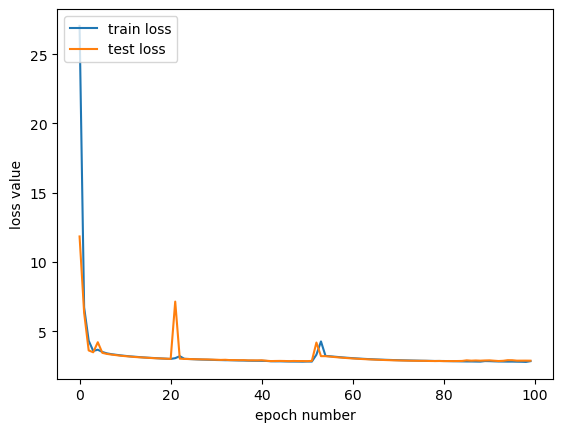

In [28]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

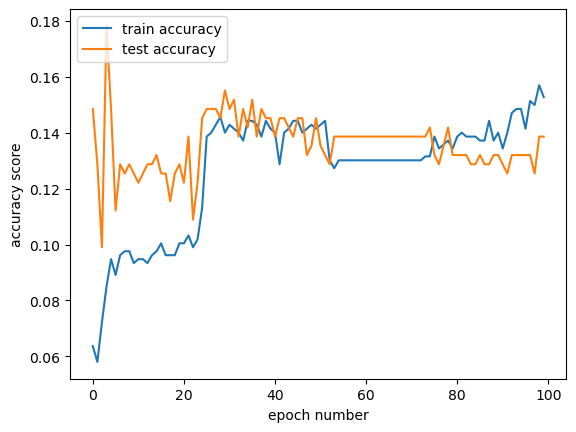

In [29]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 2

In [30]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(18, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_2 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose=1, validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 12:11:11.812797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 6.4783 - accuracy: 0.0800

2023-03-27 12:11:13.093575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 5s 4s/step - loss: 6.4783 - accuracy: 0.0800 - val_loss: 10.6375 - val_accuracy: 0.1386
Epoch 2/100
2/2 [==============================] - 5s 4s/step - loss: 9.9159 - accuracy: 0.0800 - val_loss: 6.2487 - val_accuracy: 0.0594
Epoch 3/100
2/2 [==============================] - 4s 4s/step - loss: 6.3128 - accuracy: 0.0600 - val_loss: 4.1301 - val_accuracy: 0.0429
Epoch 4/100
2/2 [==============================] - 4s 4s/step - loss: 4.0212 - accuracy: 0.0200 - val_loss: 4.0368 - val_accuracy: 0.0363
Epoch 5/100
2/2 [==============================] - 4s 4s/step - loss: 4.0658 - accuracy: 0.0400 - val_loss: 4.0271 - val_accuracy: 0.0462
Epoch 6/100
2/2 [==============================] - 4s 4s/step - loss: 4.0247 - accuracy: 0.1000 - val_loss: 4.0745 - val_accuracy: 0.1452
Epoch 7/100
2/2 [==============================] - 4s 4s/step - loss: 4.0726 - accuracy: 0.1800 - val_loss: 4.0973 - val_accuracy: 0.1650
Epoch 8/100
2/2 [============================

2/2 [==============================] - 4s 4s/step - loss: 3.2814 - accuracy: 0.2200 - val_loss: 3.4048 - val_accuracy: 0.2013
Epoch 61/100
2/2 [==============================] - 4s 4s/step - loss: 3.1271 - accuracy: 0.3800 - val_loss: 3.4038 - val_accuracy: 0.2013
Epoch 62/100
2/2 [==============================] - 4s 4s/step - loss: 2.9692 - accuracy: 0.2500 - val_loss: 3.3920 - val_accuracy: 0.1947
Epoch 63/100
2/2 [==============================] - 4s 4s/step - loss: 3.3472 - accuracy: 0.3000 - val_loss: 3.4079 - val_accuracy: 0.1947
Epoch 64/100
2/2 [==============================] - 4s 4s/step - loss: 3.1534 - accuracy: 0.3000 - val_loss: 3.3751 - val_accuracy: 0.2376
Epoch 65/100
2/2 [==============================] - 4s 4s/step - loss: 3.0117 - accuracy: 0.3200 - val_loss: 3.4137 - val_accuracy: 0.2475
Epoch 66/100
2/2 [==============================] - 4s 4s/step - loss: 3.0753 - accuracy: 0.2600 - val_loss: 3.4168 - val_accuracy: 0.2442
Epoch 67/100
2/2 [======================

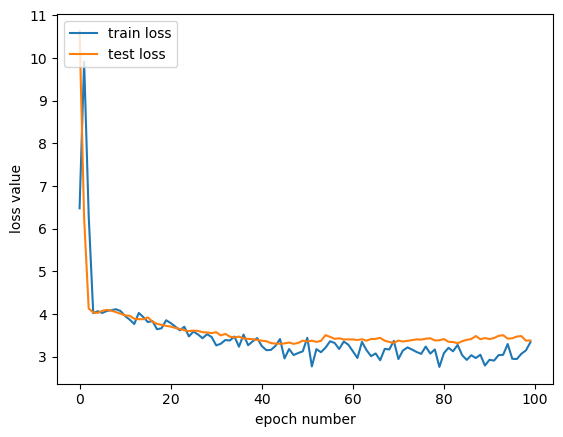

In [31]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

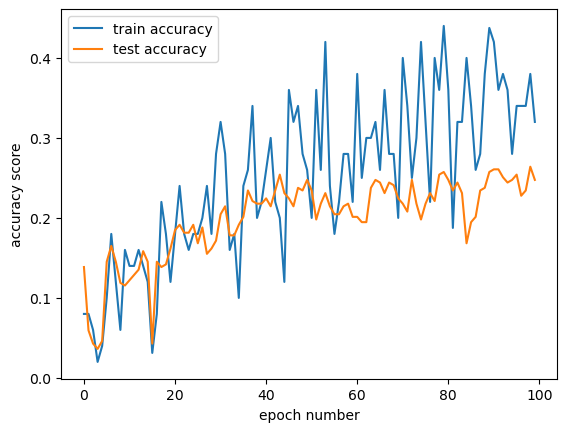

In [32]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 3

In [35]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.1))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(18, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_3 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose=1, validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 12:22:50.044250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 8.7294 - accuracy: 0.0800

2023-03-27 12:22:51.363808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 5s 4s/step - loss: 8.7294 - accuracy: 0.0800 - val_loss: 5.9140 - val_accuracy: 0.0528
Epoch 2/100
2/2 [==============================] - 4s 4s/step - loss: 6.2830 - accuracy: 0.0400 - val_loss: 3.9136 - val_accuracy: 0.0858
Epoch 3/100
2/2 [==============================] - 4s 4s/step - loss: 4.6354 - accuracy: 0.0200 - val_loss: 4.0652 - val_accuracy: 0.0561
Epoch 4/100
2/2 [==============================] - 4s 4s/step - loss: 4.1027 - accuracy: 0.1000 - val_loss: 4.1228 - val_accuracy: 0.0462
Epoch 5/100
2/2 [==============================] - 4s 4s/step - loss: 4.1307 - accuracy: 0.0400 - val_loss: 4.1197 - val_accuracy: 0.0594
Epoch 6/100
2/2 [==============================] - 4s 4s/step - loss: 4.1077 - accuracy: 0.0312 - val_loss: 4.1167 - val_accuracy: 0.0891
Epoch 7/100
2/2 [==============================] - 4s 4s/step - loss: 4.1003 - accuracy: 0.0800 - val_loss: 4.0967 - val_accuracy: 0.0957
Epoch 8/100
2/2 [=============================

2/2 [==============================] - 4s 4s/step - loss: 3.3621 - accuracy: 0.2400 - val_loss: 3.4065 - val_accuracy: 0.2013
Epoch 61/100
2/2 [==============================] - 4s 4s/step - loss: 3.3009 - accuracy: 0.3000 - val_loss: 3.3826 - val_accuracy: 0.1914
Epoch 62/100
2/2 [==============================] - 4s 4s/step - loss: 3.4567 - accuracy: 0.1400 - val_loss: 3.3652 - val_accuracy: 0.1749
Epoch 63/100
2/2 [==============================] - 4s 4s/step - loss: 3.3761 - accuracy: 0.1800 - val_loss: 3.3478 - val_accuracy: 0.1749
Epoch 64/100
2/2 [==============================] - 4s 4s/step - loss: 3.4242 - accuracy: 0.1200 - val_loss: 3.3381 - val_accuracy: 0.1749
Epoch 65/100
2/2 [==============================] - 4s 4s/step - loss: 3.2339 - accuracy: 0.2200 - val_loss: 3.3272 - val_accuracy: 0.1749
Epoch 66/100
2/2 [==============================] - 4s 4s/step - loss: 3.1815 - accuracy: 0.2600 - val_loss: 3.3212 - val_accuracy: 0.1815
Epoch 67/100
2/2 [======================

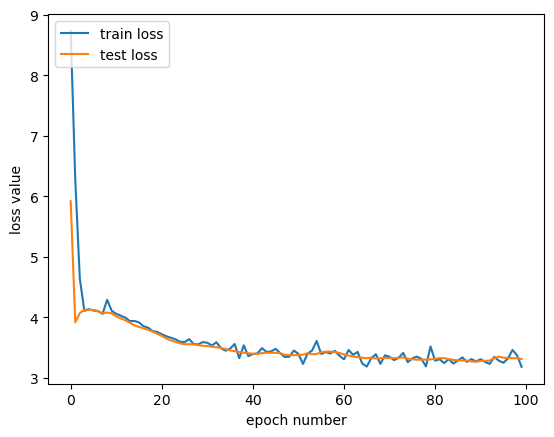

In [36]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

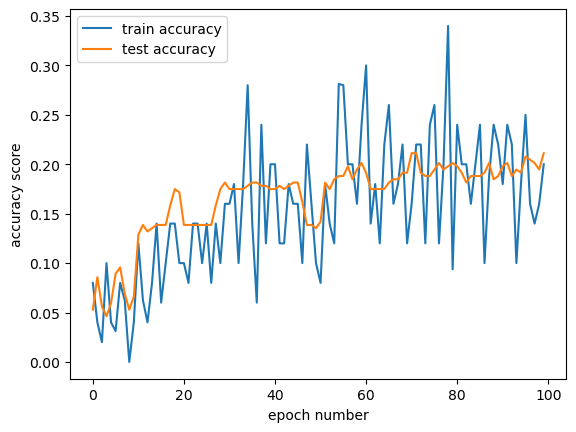

In [37]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 4

In [38]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(18, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_4 = model.fit(
        train_generator, steps_per_epoch = 2, validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 12:35:40.600094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 5.9395 - accuracy: 0.0400

2023-03-27 12:35:41.288850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 1s/step - loss: 5.9395 - accuracy: 0.0400 - val_loss: 4.8323 - val_accuracy: 0.1023
Epoch 2/100
2/2 [==============================] - 1s 1s/step - loss: 4.4973 - accuracy: 0.1000 - val_loss: 3.3514 - val_accuracy: 0.0561
Epoch 3/100
2/2 [==============================] - 1s 1s/step - loss: 3.3524 - accuracy: 0.0000e+00 - val_loss: 3.3570 - val_accuracy: 0.0297
Epoch 4/100
2/2 [==============================] - 1s 1s/step - loss: 3.3943 - accuracy: 0.0000e+00 - val_loss: 3.3709 - val_accuracy: 0.0297
Epoch 5/100
2/2 [==============================] - 1s 1s/step - loss: 3.4296 - accuracy: 0.0000e+00 - val_loss: 3.3964 - val_accuracy: 0.1155
Epoch 6/100
2/2 [==============================] - 1s 1s/step - loss: 3.3967 - accuracy: 0.0800 - val_loss: 3.3976 - val_accuracy: 0.1320
Epoch 7/100
2/2 [==============================] - 1s 1s/step - loss: 3.3975 - accuracy: 0.1400 - val_loss: 3.4107 - val_accuracy: 0.0726
Epoch 8/100
2/2 [=================

2/2 [==============================] - 1s 1s/step - loss: 2.9529 - accuracy: 0.2200 - val_loss: 2.9968 - val_accuracy: 0.1749
Epoch 61/100
2/2 [==============================] - 1s 928ms/step - loss: 2.9532 - accuracy: 0.1562 - val_loss: 2.9944 - val_accuracy: 0.1551
Epoch 62/100
2/2 [==============================] - 1s 1s/step - loss: 2.9794 - accuracy: 0.2800 - val_loss: 2.9865 - val_accuracy: 0.1650
Epoch 63/100
2/2 [==============================] - 1s 1s/step - loss: 2.9227 - accuracy: 0.1800 - val_loss: 2.9682 - val_accuracy: 0.1914
Epoch 64/100
2/2 [==============================] - 1s 1s/step - loss: 2.8915 - accuracy: 0.2000 - val_loss: 2.9625 - val_accuracy: 0.1848
Epoch 65/100
2/2 [==============================] - 1s 1s/step - loss: 2.9713 - accuracy: 0.1600 - val_loss: 2.9765 - val_accuracy: 0.1749
Epoch 66/100
2/2 [==============================] - 1s 1s/step - loss: 2.9389 - accuracy: 0.2600 - val_loss: 3.0019 - val_accuracy: 0.1782
Epoch 67/100
2/2 [===================

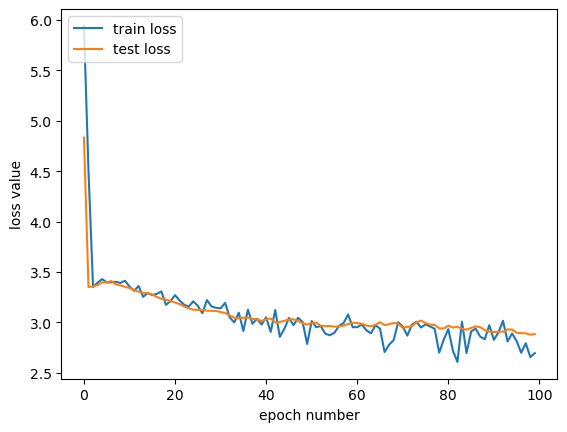

In [39]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

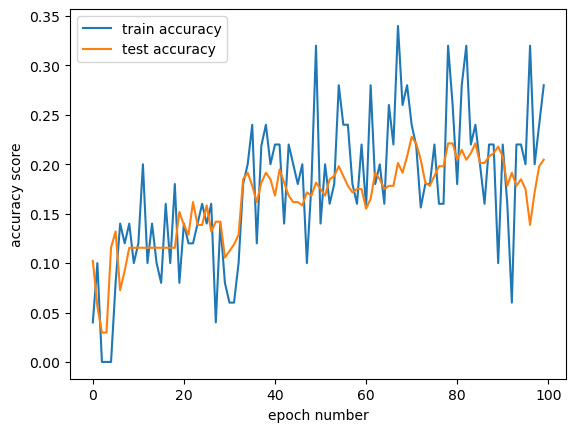

In [40]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 5